In [8]:
import pandas as pd
import numpy as np
from random import Random
import matplotlib.pyplot as plt
from progressbar import ProgressBar

seed = 4621
myPRNG = Random(seed)

# create a continuous valued chromosome 
def createChromosome(d, lBnd, uBnd):   
    x = []
    for i in range(d):
        x.append(myPRNG.uniform(lBnd,uBnd))   #creating a randomly located solution
    
    # normalize values for Markowitz constraint
    for i in range(len(x)):
        x[i] = x[i] / sum(x)
      
    return x

# create initial population
def initializePopulation(): 
    population = []
    populationFitness = []
    
    print("Initializing Population")
    pbar = ProgressBar()
    for i in pbar(range(populationSize)):
        population.append(createChromosome(R['coin'].count(),0,1))
        populationFitness.append(evaluate(population[i]))
        
    tempZip = zip(population, populationFitness)
    popVals = sorted(tempZip, key=lambda tempZip: tempZip[1])
    
    return popVals   

# helper method to calculate covariance used in sharpe ratio
def covariance(x, y):
    symbol_x = df['coin'].unique()[x]
    symbol_y = df['coin'].unique()[y]   
    val_x = df[df['coin']==symbol_x]['return'].values
    val_y = df[df['coin']==symbol_y]['return'].values
    cov = (val_x * val_y).mean() - (val_x.mean() * val_y.mean())
    return cov

# function to evaluate the Sharpe ratio of the portfolio
def evaluate(w):     
    
    Rp = 0 # portfolio return 
    Rf = 1.0 # risk free return
    sigma = 0 # portfolio variance
    
     # calculate portfolio return
    for i in range(len(w)):
        Rp = Rp + R['return'].iloc[i] * w[i]
        
    # calculate portfolio variance
    for i in range(len(w)):
        for j in range(len(w)):
            sigma = sigma + (covariance(i,j) * w[i] * w[j])
            
    sharpe = (Rp - Rf) / sigma
    
    frontierData.append((Rp,sigma,sharpe))
    
    return sharpe   

# performs tournament selection; k chromosomes are selected (with repeats allowed) and the best advances to the mating pool
# function returns the mating pool with size equal to the initial population
def tournamentSelection(pop,k):
    
    #randomly select k chromosomes; the best joins the mating pool
    matingPool = []
    
    print("Tournament Selection")
    while len(matingPool)<populationSize:
        
        ids = [myPRNG.randint(0,populationSize-1) for i in range(k)]
        competingIndividuals = [pop[i][1] for i in ids]
        bestID=ids[competingIndividuals.index(max(competingIndividuals))]
        matingPool.append(pop[bestID][0])

    return matingPool

def breeding(matingPool):
    children = []
    childrenFitness = []
    
    print("Breeding Offspring")
    pbar = ProgressBar()
    for i in pbar(range(0,populationSize-1,2)):

        child1,child2=crossover(matingPool[i],matingPool[i+1])
        
        child1=mutate(child1)
        child2=mutate(child2)
        
        # normalize values for Markowitz constraint
        for i in range(len(child1)):
            child1[i] = child1[i] / sum(child1)
            child2[i] = child2[i] / sum(child2)
        
        children.append(child1)
        children.append(child2)
        
        childrenFitness.append(evaluate(child1))
        childrenFitness.append(evaluate(child2))
        
    tempZip = zip(children, childrenFitness)
    popVals = sorted(tempZip, key=lambda tempZip: tempZip[1])
    
    return popVals

# implement a linear crossover
def crossover(x1,x2):
    # randomly generate probability of crossover
    probability = myPRNG.uniform(0, 1)
      
    if probability <= crossOverRate: 

        #choose the crossover point so that at least 1 element of parent is copied
        crossOverPt = myPRNG.randint(1,len(x1)-1) 

        beta = myPRNG.random()  #random number between 0 and 1

        #create the linear combination of the solutions
        new1 = list(np.array(x1) - beta*(np.array(x1)-np.array(x2))) 
        new2 = list(np.array(x2) + beta*(np.array(x1)-np.array(x2)))

        #perfrom the crossover between the original solutions "x1" and "x2" and the "new1" and "new2" solutions
        if crossOverPt < len(x1)/2:    
            offspring1 = x1[0:crossOverPt] + new1[crossOverPt:len(x1)]
            offspring2 = x2[0:crossOverPt] + new2[crossOverPt:len(x1)]
        else:
            offspring1 = new1[0:crossOverPt] + x1[crossOverPt:len(x1)]
            offspring2 = new2[0:crossOverPt] + x2[crossOverPt:len(x1)]        
    else:
        offspring1 = x1
        offspring2 = x2
      
    return offspring1, offspring2

# mutate function 
def mutate(x):
    # randomly generate probability of mutation
    probability = myPRNG.uniform(0, 1)
    
    # mutate if less than mutationRate
    if probability <= mutationRate:
        # random position to mutate
        index = myPRNG.randint(0, len(x)-1)

        # solution feasbile flag (0 infeasible, 1 feasible)
        flag = 0 

        # loop until feasible mutation found
        while flag == 0:
            x[index] = myPRNG.uniform(0, 1)
            if (evaluate(x) > 0):
                flag = 1
    return x

# insertion step using elitism strategy
def insert(pop,kids):
    
    # sort parents for elitism strategy
    popVals = sorted(pop, key=lambda pop: pop[1])
    
    # sort kids for elistim strategy
    kidVals = sorted(kids, key=lambda kids: kids[1])
   
    # combine top parents with top kids for next generation
    population = popVals[:elitismCount] + kidVals[:(populationSize-elitismCount)]
    
    return population 

# display fitness of population
def summaryFitness(pop):
    a=np.array(list(zip(*pop))[1])
    return np.max(a), np.mean(a), np.var(a)

# display best solution
def bestSolutionInPopulation(pop):
    print ("Best Portfolio: " , pop[len(population)-1])

In [9]:
# load porfolio data
df = pd.read_csv('../annualreturns.csv') 
R = pd.read_csv('../modelreturns.csv')

# set GA parameters
populationSize = 10 #size of GA population
generations = 1   #number of GA generations
crossOverRate = 0.8  #crossover rate
mutationRate = 0.2   #mutation rate
elitismCount = 0   #number of parents to keep in each generation, 0 for no elitism
frontierData = []

print("Population Size:", populationSize)
print("Generations:", generations)
print("CrossOverRate:", crossOverRate)
print("MutationRate", mutationRate)

# set initial population
population = initializePopulation()

# GA main loop
for j in range(generations): 
    print("Generation: ", j)
        
    # genetic algorithm
    mates=tournamentSelection(population,3)
    offspring = breeding(mates)
    population = insert(population, offspring)
    
    # show generation statistics
    maxVal,meanVal,varVal=summaryFitness(population)
    print("Max: ", maxVal, "Mean: ", meanVal, "Variance", varVal)  

# show best solution
bestSolutionInPopulation(population)

Population Size: 10
Generations: 1
CrossOverRate: 0.8
MutationRate 0.2
Initializing Population


<ipython-input-8-2173564baa48>:63: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = (Rp - Rf) / sigma
100% |########################################################################|


Generation:  0
Tournament Selection
Breeding Offspring


Max:  inf Mean:  inf Variance nan
Best Portfolio:  ([0.001985895370772833, 0.007090377128707647, 0.007336062419087528, 0.0020107060245108184, 0.005238197648792626, 0.006842330113202223, 0.006949128942650639, 0.0013390333764101343, 0.0013335305013759233, 0.004166189278842934, 0.0006890688736959805, 0.002804981594207157, 0.00041125914792108757, 0.004480991208048959, 0.00654728770500328, 0.004190752279931563, 0.005382080793022277, 0.0025601135096295735, 0.0066802921746816546, 0.0009382329439625366, 0.003945954325595959, 0.006984905691883612, 0.000602478091401063, 0.008894814574144629, 0.005069994743549171, 0.0020158115966973913, 0.006706529500800502, 0.0034640789542424357, 0.0003235922988010862, 0.010945803834425111, 0.0021287700907973617, 0.0006182215538917113, 0.0017733521939285605, 0.008701808422685838, 0.009322620666974493, 0.012153869408201517, 0.010263936251440843, 0.009804820655866523, 0.012905180159849159, 0.012730236926251255, 0.010766646382207739, 0.0035168646250216965, 0.009948


c:\python38\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


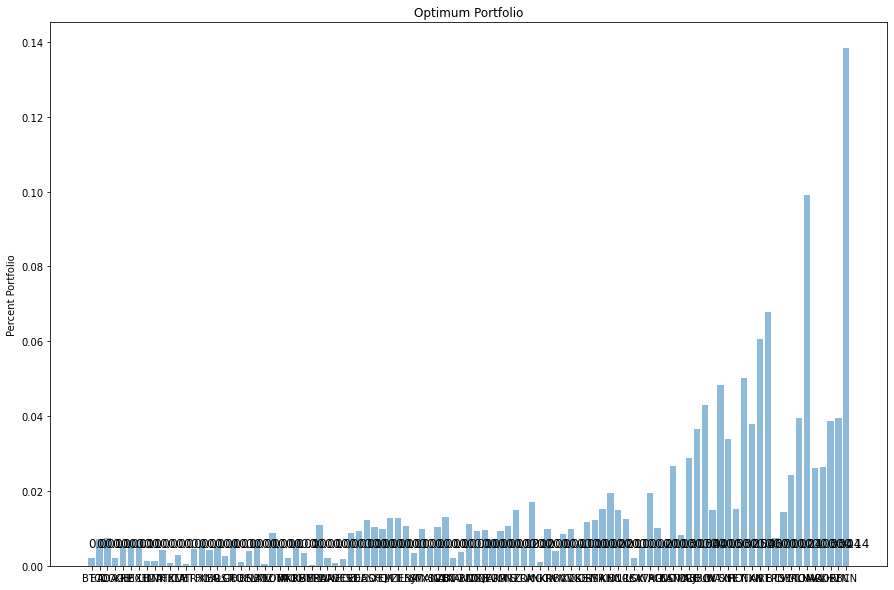

In [10]:
Portfolio = R.copy()
Portfolio['Optimum'] = population[len(population)-1][0]
labels = population[len(population)-1][0]

fig = plt.figure(figsize=(15,10))

objects = Portfolio['coin']
y_pos = np.arange(len(objects))
performance = Portfolio['Optimum']

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percent Portfolio')
plt.title('Optimum Portfolio')

total = 0
for i, v in enumerate(labels):
    plt.text(i-.4, 0.005, round(labels[i],2), fontsize=12, color='k')
    total = total + round(labels[i],2)

plt.show()

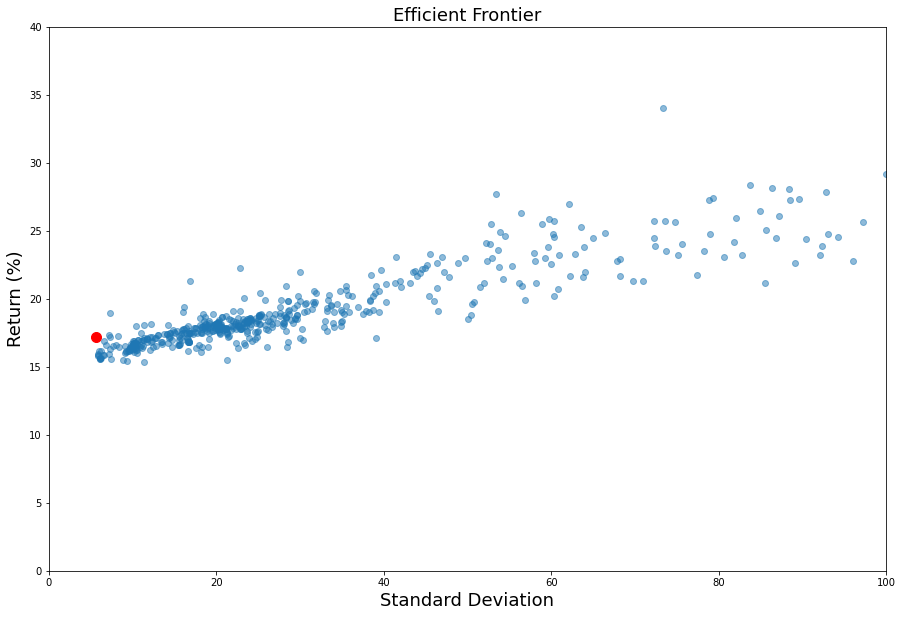

In [22]:
frontier_df = pd.DataFrame(frontierData,columns=['Return','Sigma','Sharpe'])
fig = plt.figure(figsize=(15,10))
x = frontier_df['Sigma'].values
y = frontier_df['Return'].values
optimum_x = frontier_df[frontier_df['Sharpe'] == Best[1]]['Sigma']
optimum_y = frontier_df[frontier_df['Sharpe'] == Best[1]]['Return']
plt.ylim(0, 40)
plt.xlim(0, 100)
plt.title('Efficient Frontier', fontsize=18)
plt.xlabel('Standard Deviation', fontsize=18)
plt.ylabel('Return (%)', fontsize=18)
plt.scatter(x, y, alpha=0.5)
plt.plot(optimum_x, optimum_y, color='r', marker=".", markersize=20)
plt.show()